In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

def generate_image_paths(images_folder):
    veggies_image_paths = {}
    for veggie_name in os.listdir(images_folder):
        veggie_folder_path = os.path.join(images_folder, veggie_name)
        if os.path.isdir(veggie_folder_path):
            image_paths = [os.path.join(veggie_folder_path, file) for file in os.listdir(veggie_folder_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.JPG', '.JPEG', '.PNG', '.GIF'))]
            veggies_image_paths[veggie_name] = image_paths
    return veggies_image_paths

images_folder = "archive/train"
veggies_image_paths = generate_image_paths(images_folder)

In [3]:
veggies_image_paths

{'apple': ['archive/train/apple/Image_28.jpg',
  'archive/train/apple/Image_16.jpg',
  'archive/train/apple/Image_17.jpg',
  'archive/train/apple/Image_38.jpg',
  'archive/train/apple/Image_10.jpg',
  'archive/train/apple/Image_39.jpg',
  'archive/train/apple/Image_76.png',
  'archive/train/apple/Image_62.jpg',
  'archive/train/apple/Image_63.jpg',
  'archive/train/apple/Image_61.jpg',
  'archive/train/apple/Image_49.jpg',
  'archive/train/apple/Image_48.jpg',
  'archive/train/apple/Image_9.jpg',
  'archive/train/apple/Image_60.jpg',
  'archive/train/apple/Image_58.jpg',
  'archive/train/apple/Image_64.jpg',
  'archive/train/apple/Image_65.png',
  'archive/train/apple/Image_71.png',
  'archive/train/apple/Image_59.png',
  'archive/train/apple/Image_67.jpg',
  'archive/train/apple/Image_57.jpg',
  'archive/train/apple/Image_2.jpg',
  'archive/train/apple/Image_43.jpg',
  'archive/train/apple/Image_80.jpg',
  'archive/train/apple/Image_42.jpg',
  'archive/train/apple/Image_56.jpg',
  'ar

In [4]:
import pandas as pd

veggie_df = pd.DataFrame([(folder, path) for folder, paths in veggies_image_paths.items() for path in paths], columns=['veggie_name', 'image_path'])
veggie_df

,veggie_name,image_path
0,apple,archive/train/apple/Image_28.jpg
1,apple,archive/train/apple/Image_16.jpg
2,apple,archive/train/apple/Image_17.jpg
3,apple,archive/train/apple/Image_38.jpg
4,apple,archive/train/apple/Image_10.jpg
...,...,...
3110,carrot,archive/train/carrot/Image_10.jpeg
3111,carrot,archive/train/carrot/Image_27.jpg
3112,carrot,archive/train/carrot/Image_31.jpg
3113,carrot,archive/train/carrot/Image_25.jpg


In [5]:
print(veggie_df.veggie_name.unique())
print(len(veggie_df.veggie_name.unique()))

['apple' 'turnip' 'chilli pepper' 'raddish' 'bell pepper' 'pear'
 'sweetpotato' 'pomegranate' 'peas' 'capsicum' 'spinach' 'lettuce' 'kiwi'
 'lemon' 'onion' 'cauliflower' 'potato' 'jalepeno' 'sweetcorn' 'cucumber'
 'paprika' 'watermelon' 'mango' 'cabbage' 'grapes' 'beetroot' 'eggplant'
 'corn' 'soy beans' 'banana' 'ginger' 'garlic' 'pineapple' 'tomato'
 'orange' 'carrot']
36


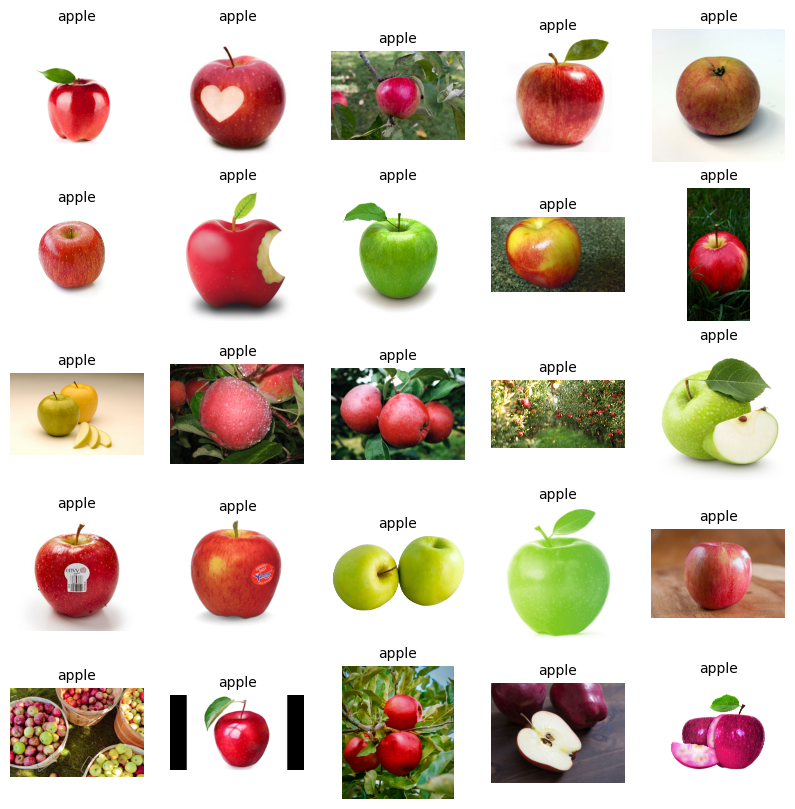

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):
    
    img_path = veggie_df.iloc[i]['image_path']
    label = veggie_df.iloc[i]['veggie_name']  
    
    ax.set_title(label, size=10)
    ax.imshow(Image.open(str(img_path)))
    ax.axis(False)

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

centering = transforms.Lambda(lambda x: x - torch.mean(x))
standardization = transforms.Lambda(lambda x: (x - torch.mean(x)) / torch.std(x))
augmentation = transforms.RandomHorizontalFlip(p=1)
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
contrast_adjustment = transforms.ColorJitter(contrast=2.0)
rotation = transforms.RandomRotation(degrees=30)

transform = transforms.Compose([
    transforms.Resize((250, 250)), 
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    centering,
    standardization,
    augmentation,
    gaussian_blur,
    contrast_adjustment,
    rotation
])

In [8]:
train_df = datasets.ImageFolder(root='archive/Train', transform=transform)
print(train_df)

transform_test = transforms.Compose([
    transforms.Resize((250, 250)), 
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_df = datasets.ImageFolder(root='archive/Validation', transform=transform_test)
test_df = datasets.ImageFolder(root='archive/Test', transform=transform_test)

Dataset ImageFolder
    Number of datapoints: 3115
    Root location: archive/Train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               Lambda()
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Lambda()
               Lambda()
               RandomHorizontalFlip(p=1)
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               ColorJitter(brightness=None, contrast=(0.0, 3.0), saturation=None, hue=None)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )


In [9]:
train_loader = torch.utils.data.DataLoader(train_df, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_df, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_df, batch_size=32, shuffle=True)

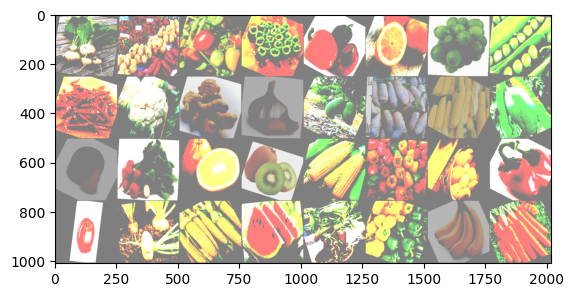

In [11]:
import torchvision
import numpy as np

def imshow(img):
    plt.imshow(np.transpose(img/2+0.5, (1,2,0)))
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

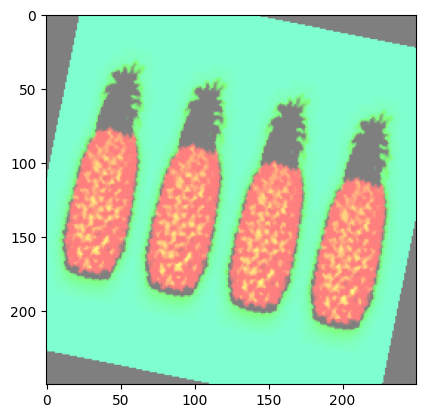

In [14]:
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.transpose(img/2+0.5, (1,2,0)))
    
dataiter = iter(train_loader)
images, labels = next(dataiter) 
images = images.numpy()

for index in np.arange(32):
    imshow(images[index])

In [49]:
import torch.nn as nn

class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 31 * 31, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 36)  # Number of output classes
        )

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.conv_layers(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers
        x = self.fc_layers(x)
        return x


In [50]:
model = MultiClassCNN()
print(model)

MultiClassCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=123008, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=512, out_features=36, bias=True)
  )
)


In [54]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5
train_loss = []
valid_loss = []
valid_accuracy = []  # Track validation accuracy

for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data.size(0)
    train_loss.append(epoch_train_loss / len(train_loader.dataset))
    
    model.eval()
    epoch_valid_loss = 0.
    correct = 0 
    total = 0 
    
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        epoch_valid_loss += loss.item() * data.size(0)
    
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    valid_loss.append(epoch_valid_loss / len(valid_loader.dataset))
    
    # Calculate validation accuracy
    accuracy = 100 * correct / total
    valid_accuracy.append(accuracy)

    print('Epoch', epoch, 'Train Loss:', train_loss[-1], 'Valid Loss:', valid_loss[-1], 'Valid Accuracy:', accuracy)

Epoch 0 Train Loss: 3.6212288306191875 Valid Loss: 8.168778969691349 Valid Accuracy: 3.4188034188034186
Epoch 1 Train Loss: 3.623181209824441 Valid Loss: 8.263242161851323 Valid Accuracy: 2.849002849002849
Epoch 2 Train Loss: 3.6252089952771964 Valid Loss: 8.17109315959137 Valid Accuracy: 2.849002849002849
Epoch 3 Train Loss: 3.6342476136803055 Valid Loss: 7.196132522702556 Valid Accuracy: 2.2792022792022792
Epoch 4 Train Loss: 3.638269115374521 Valid Loss: 7.243207858158992 Valid Accuracy: 3.7037037037037037


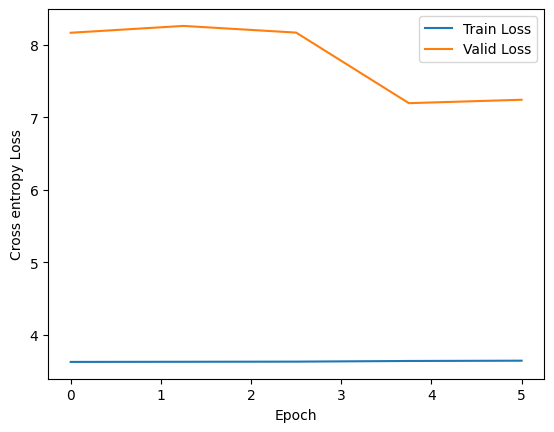

In [55]:
def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(0, epochs, epochs), train_loss, valid_loss)

In [56]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_loss = []
valid_loss = []
valid_accuracy = []  # Track validation accuracy

for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data.size(0)
    train_loss.append(epoch_train_loss / len(train_loader.dataset))
    
    model.eval()
    epoch_valid_loss = 0.
    correct = 0 
    total = 0 
    
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        epoch_valid_loss += loss.item() * data.size(0)
    
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    valid_loss.append(epoch_valid_loss / len(valid_loader.dataset))
    
    # Calculate validation accuracy
    accuracy = 100 * correct / total
    valid_accuracy.append(accuracy)

    print('Epoch', epoch, 'Train Loss:', train_loss[-1], 'Valid Loss:', valid_loss[-1], 'Valid Accuracy:', accuracy)

Epoch 0 Train Loss: 3.6114277586316987 Valid Loss: 7.195975413689246 Valid Accuracy: 1.9943019943019944
Epoch 1 Train Loss: 3.5886388502381203 Valid Loss: 7.211333839981644 Valid Accuracy: 1.9943019943019944
Epoch 2 Train Loss: 3.5867863132329854 Valid Loss: 7.163477033631414 Valid Accuracy: 1.9943019943019944
Epoch 3 Train Loss: 3.5889798663401105 Valid Loss: 7.181990916912373 Valid Accuracy: 2.5641025641025643
Epoch 4 Train Loss: 3.588758674594028 Valid Loss: 7.233189262216247 Valid Accuracy: 1.9943019943019944
Epoch 5 Train Loss: 3.5873136565543677 Valid Loss: 7.321043149018899 Valid Accuracy: 1.9943019943019944
Epoch 6 Train Loss: 3.585978791878273 Valid Loss: 7.283532692835881 Valid Accuracy: 1.9943019943019944
Epoch 7 Train Loss: 3.588206725480277 Valid Loss: 7.2604580224409405 Valid Accuracy: 1.7094017094017093


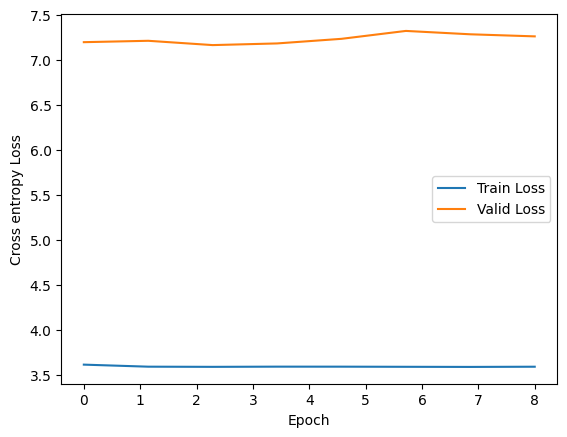

In [57]:
plot_loss_curves(np.linspace(0, epochs, epochs), train_loss, valid_loss)

In [60]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 8
train_loss = []
valid_loss = []
valid_accuracy = []  # Track validation accuracy

for epoch in range(epochs):
    epoch_train_loss = 0.
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * data.size(0)
    train_loss.append(epoch_train_loss / len(train_loader.dataset))
    
    model.eval()
    epoch_valid_loss = 0.
    correct = 0 
    total = 0 
    
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        epoch_valid_loss += loss.item() * data.size(0)
    
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    valid_loss.append(epoch_valid_loss / len(valid_loader.dataset))
    
    # Calculate validation accuracy
    accuracy = 100 * correct / total
    valid_accuracy.append(accuracy)

    print('Epoch', epoch, 'Train Loss:', train_loss[-1], 'Valid Loss:', valid_loss[-1], 'Valid Accuracy:', accuracy)

Epoch 0 Train Loss: 4.160716895383587 Valid Loss: 12.07311271602272 Valid Accuracy: 0.5698005698005698
Epoch 1 Train Loss: 3.751852660998104 Valid Loss: 12.015875164260212 Valid Accuracy: 0.8547008547008547
Epoch 2 Train Loss: 3.675939368665888 Valid Loss: 11.948378883535705 Valid Accuracy: 1.1396011396011396
Epoch 3 Train Loss: 3.655659049050957 Valid Loss: 11.985585519730876 Valid Accuracy: 1.1396011396011396
Epoch 4 Train Loss: 3.6244632381114683 Valid Loss: 11.976414281078894 Valid Accuracy: 1.1396011396011396
Epoch 5 Train Loss: 3.626690192169018 Valid Loss: 11.916256274253215 Valid Accuracy: 1.1396011396011396
Epoch 6 Train Loss: 3.6183061334141566 Valid Loss: 11.990080012894763 Valid Accuracy: 1.7094017094017093
Epoch 7 Train Loss: 3.6072138706715493 Valid Loss: 11.923530757936657 Valid Accuracy: 2.5641025641025643


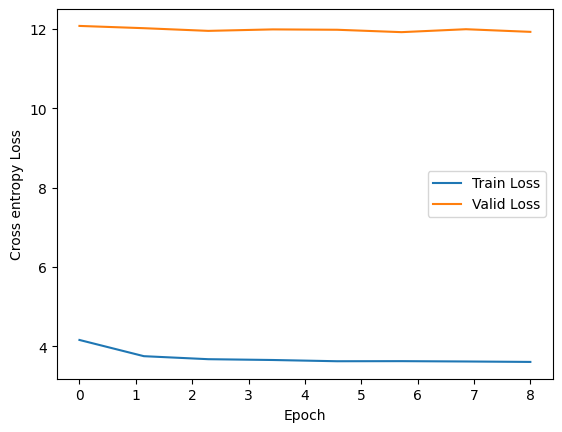

In [61]:
plot_loss_curves(np.linspace(0, epochs, epochs), train_loss, valid_loss)

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
num_classes = 36

train_data_dir = 'archive/train'
validation_data_dir = 'archive/validation'
test_data_dir = 'archive/test'

In [67]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [68]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [69]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [70]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3115 images belonging to 36 classes.


In [71]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 351 images belonging to 36 classes.


In [72]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 359 images belonging to 36 classes.


In [73]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_history_2 = model.fit(
                         train_generator,
                             epochs =10 ,
                             validation_data = validation_generator,
                               batch_size = 32,
     
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.2999 - loss: 2.7584 - val_accuracy: 0.7749 - val_loss: 0.6882
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7506 - loss: 0.8616 - val_accuracy: 0.8889 - val_loss: 0.3871
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.8114 - loss: 0.6013 - val_accuracy: 0.8661 - val_loss: 0.4565
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8566 - loss: 0.4645 - val_accuracy: 0.9088 - val_loss: 0.2935
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8695 - loss: 0.3853 - val_accuracy: 0.9145 - val_loss: 0.2588
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9003 - loss: 0.3095 - val_accuracy: 0.9117 - val_loss: 0.2660
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9081 - loss: 0.2801 - val_accuracy: 0.9288 - val_loss: 0.2059
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9385 - loss: 0.1966 - val_accuracy: 0.9430 - v

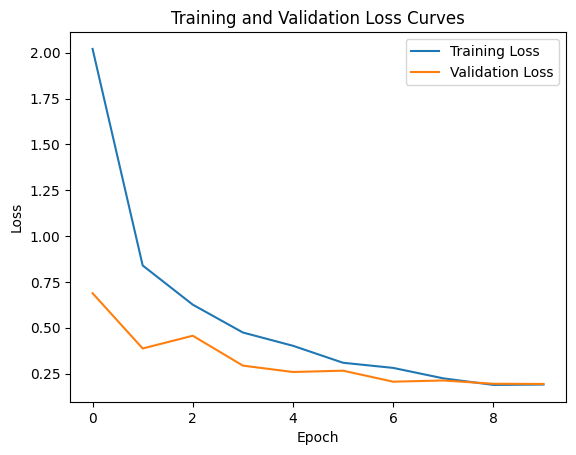

In [76]:
def plot_loss_graph():
    train_loss = model_history_2.history['loss']
    val_loss = model_history_2.history['val_loss']
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss_graph()

In [77]:
train_loss, train_accuracy = model.evaluate(train_generator)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)

98/98 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9564 - loss: 0.1343
Training Loss: 0.14119403064250946
Training Accuracy: 0.9550561904907227


In [124]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : apple
1 : banana
2 : beetroot
3 : bell pepper
4 : cabbage
5 : capsicum
6 : carrot
7 : cauliflower
8 : chilli pepper
9 : corn
10 : cucumber
11 : eggplant
12 : garlic
13 : ginger
14 : grapes
15 : jalepeno
16 : kiwi
17 : lemon
18 : lettuce
19 : mango
20 : onion
21 : orange
22 : paprika
23 : pear
24 : peas
25 : pineapple
26 : pomegranate
27 : potato
28 : raddish
29 : soy beans
30 : spinach
31 : sweetcorn
32 : sweetpotato
33 : tomato
34 : turnip
35 : watermelon


In [128]:
class_map = dict([v,k] for k,v in train_generator.class_indices.items())
print(class_map)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


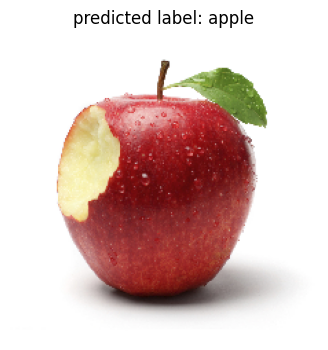

In [148]:
import numpy as np
test_image_path ="archive/test/apple/Image_10.jpg"
def predictions(test_image_path):

    #load and preprocessing image
    test_img = image.load_img(test_image_path, target_size = (224, 224))
    test_img_arr = image.img_to_array(test_img)/ 255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1] , test_img_arr.shape[2]))

    # prediction
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_img = class_map[predicted_label]


    plt.figure(figsize = (4,4))
    plt.imshow(test_img_arr)
    plt.title("predicted label: {}".format (predicted_img))
    plt.grid()
    plt.axis('off')
    plt.show()

predictions(test_image_path)